In [8]:
import os
from os.path import join
from time import time
from tqdm.notebook import tqdm

import numpy as np
from numpy import flatnonzero as find
from scipy.sparse import hstack, vstack
from scipy.sparse.linalg import spsolve

from data import case_as_data, PowerflowData, PowerflowOptimData


In [9]:
data = case_as_data('case300')
pf = PowerflowData(data)

$j$ denotes imaginary unit in electrical engineering  
$Y_{bus} = Y = G + jB$  
$S_{bus} = S = P + jQ$  
$V_i = |V_i|e^{j\delta_i}$  
$\theta_{ik} = \delta_i - \delta_k$

$S_k = V_k \cdot (YV)_k^*$  
or   
$P_{i}=\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\cos \theta _{{ik}}+B_{{ik}}\sin \theta _{{ik}})$    
$Q_{i}=\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\sin \theta _{{ik}}-B_{{ik}}\cos \theta _{{ik}})$  
Further reading: https://wiki.openelectrical.org/index.php?title=Power_Flow  
### Newton algorthm
$$
\Delta P_{i}=-P_{i}+\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\cos \theta _{{ik}}+B_{{ik}}\sin \theta _{{ik}})
\\
\Delta Q_{{i}}=-Q_{{i}}+\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\sin \theta _{{ik}}-B_{{ik}}\cos \theta _{{ik}})
\\
J={\begin{bmatrix}{\dfrac  {\partial \Delta P}{\partial \theta }}&{\dfrac  {\partial \Delta P}{\partial |V|}}\\{\dfrac  {\partial \Delta Q}{\partial \theta }}&{\dfrac  {\partial \Delta Q}{\partial |V|}}\end{bmatrix}}
\\
{\begin{bmatrix}\Delta \theta \\\Delta |V|\end{bmatrix}}=-J^{{-1}}{\begin{bmatrix}\Delta P\\\Delta Q\end{bmatrix}}
\\
\theta ^{{m+1}}=\theta ^{m}+\Delta \theta \,
\\
|V|^{{m+1}}=|V|^{m}+\Delta |V|\,$$   
**What is not clarified yet**: types of buses: $pv$ and $pq$

In the power-flow problem, it is assumed that the real power $P_D$ and reactive power $Q_D$ at each Load Bus are known. For this reason, Load Buses are also known as **PQ Buses**. For Generator Buses, it is assumed that the real power generated $P_G$ and the voltage magnitude $|V|$ is known. For this reason, Generator Buses are also known as **PV Buses**

In [10]:
class NewtonSolver():
    def __init__(self):
        pass
    def solve(self, regression, iterations=10, x0=None,
                 tol=1e-10, verbose=True):
        if x0 is None:
            # special case for PowerflowDataset
            if hasattr(regression, 'get_V0'): 
                x = regression.get_V0()
            else:
                x = np.random.rand(regression.A.shape[1])
        else:
            x = x0
        
        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [np.linalg.norm(regression.forward(x), 2)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        
        for i in tqdm(range(iterations)):
            if verbose:
                print(f'{np.linalg.norm(regression.forward(x), 2)}')
            J = regression.grad(x)
            F = regression.forward(x)
            dx = -spsolve(J, F) # - np.linalg.inv(J.toarray()) @ F
            x = regression.updatedV(x, dx)
            
            # update histories
            x_history.append(x)
            values_history.append(np.linalg.norm(regression.forward(x), 2))
            times_history.append(time() - start)
            
            if np.abs(values_history[-1] - values_history[-2]) <= tol:
                print(f'Newton-Raphson converged on iteration {i}')
                break
        return x_history, values_history, times_history
        

In [14]:
nr = NewtonSolver()

res = list(nr.solve(pf, iterations=10, tol=1e-13, verbose=False))

Newton-Raphson converged on iteration 8



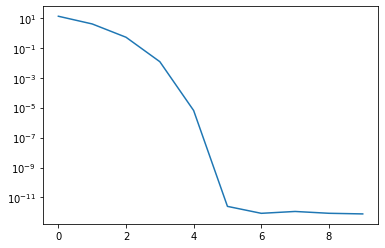

In [15]:
import matplotlib.pyplot as plt
plt.plot(res[1][:])
plt.yscale('log')

**PLS, CHECK**

In order to use optimization methods we need to transform our objective as following

$g = {\begin{bmatrix}\Delta P\\\Delta Q\end{bmatrix}}$

$f(x) = \sum \limits_{i=1}^{n}g_i^2(x)$

$\nabla_{x_i}f(x) = \sum \limits_{j=1}^{n} \frac{f(x)}{g_j(x)} \frac{g_j(x)}{x_i} = \sum \limits_{j=1}^{n} 2 g_j(x) J_{ji}(x) \rightarrow$

$\nabla f(x) = 2 J(x) \cdot g(x)$

In [22]:
# from pdb import set_trace; set_trace()
pf_optim = PowerflowOptimData(data)

In [23]:
from scipy.optimize import minimize_scalar

class ConjugateGradient():
    def __init__(self):
        pass
    
    def optimize(self, regression, iterations=10, method='fletcher-reeves', x0=None, default_step=0.01,
                line_search_iter=50, line_search_tolerance=10, tol=1e-10):
        # random guess
        if x0 is None:
            x = np.random.rand(regression.A.shape[1])
        else: 
            x = x0
        
        # conjugate direction
        d = -regression.grad(x)

        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [regression.normed_forward(x)]#[regression.forward(x)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        
        for i in tqdm(range(iterations)):
            # line search alpha
            def obj(lr):
                x_new = regression.updatedV(x, lr * d)
                return regression.forward(x_new)
            alpha = minimize_scalar(obj, bounds=(0, default_step), method='Golden',
                                    options={'maxiter':line_search_iter,
                                             'xtol': default_step / line_search_tolerance})
            if not alpha['success']:
                print(f'Line search did not converge on iteration {i}, using default step')
                alpha = default_step / (i + 1)
            else:
                alpha = alpha['x']
            
            # update x_k + 1
            if hasattr(regression, 'updatedV'): # special case for powerflowdata
                x = regression.updatedV(x, alpha * d)
            else:
                x = x + alpha * d
            x_history.append(x)
            values_history.append(regression.normed_forward(x))
            
            # compute g_k + 1
            g = regression.grad(x)
            grads_history.append(g)
            
            # update d_k + 1
            if method == 'fletcher-reeves':
                beta = (g.T @ g) / (grads_history[-2].T @ grads_history[-2])
            elif method == 'polak-ribiere':
                beta = ((g - grads_history[-2]).T @ g) / (grads_history[-2].T @ grads_history[-2])
            else:
                raise Exception(f'Unknown method: {method}')
                
            d = -g + beta * d
            
            # update times history
            times_history.append(time() - start)
            
            if np.abs(values_history[-1] - values_history[-2]) <= tol:
                print(f'Newton-Raphson converged on iteration {i}')
                break
        return x_history, values_history, times_history

In [24]:
cg = ConjugateGradient()
res = list(cg.optimize(pf_optim, iterations=3000, method='polak-ribiere',
                       line_search_iter=200, default_step=1e-8,
                       x0=pf_optim.get_V0()))

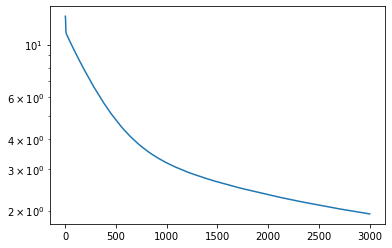

In [25]:
import matplotlib.pyplot as plt
plt.plot(res[1])
plt.yscale('log')